# Data Pre-Processing

## First, the PubMed Dataset
### Goals are to:

Extract the Q&A, have a list of all the Questions and list of all the Answers.


Label the human-answers accordingly.


Calculate relevant POS-tags for the human answers.


Calculate the perplexity of the human answers.


Plot the average perplexity of the human answers.


Have a function ready that prompts GPT with the Question and labels all the answers accordingly.


### Note, using sciSpaCy for tokenizaiton and POS-tagging as it is faster than BERT


In [53]:
#Imports 
import random
import datasets
import spacy
from collections import Counter
import torch
from transformers import BertTokenizer, BertForMaskedLM
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
#Loading the spacy small model for tokenization
nlp = spacy.load('en_core_web_sm')

#Loading SciBERT for scientific text, since the medical text is scientific
model = BertForMaskedLM.from_pretrained('allenai/scibert_scivocab_uncased')
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def calculate_perplexity(text):
    # Tokenize the text and create chunks of max length 512
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs["input_ids"]

    chunk_size = 512 - 2  # We reserve two tokens for [CLS] and [SEP]
    input_chunks = input_ids[0].split_with_sizes([chunk_size] * (input_ids.size(1) // chunk_size) + [input_ids.size(1) % chunk_size])

    perplexity = 0
    for chunk in input_chunks:
        # Add the special tokens
        chunk = torch.cat([torch.tensor([tokenizer.cls_token_id]), chunk, torch.tensor([tokenizer.sep_token_id])])

        # Calculate perplexity for this chunk
        with torch.no_grad():
            outputs = model(chunk.unsqueeze(0), labels=chunk.unsqueeze(0))
            loss = outputs.loss
        perplexity += torch.exp(loss).item()

    # Return the average perplexity
    return perplexity / len(input_chunks)

In this code, we're splitting the tokenized text into chunks of maximum length chunk_size and calculating the perplexity for each chunk individually. We then return the average perplexity over all chunks. Note that we're adding the special tokens [CLS] and [SEP] to each chunk, which BERT requires

In [12]:
#Function that loads the PubMed Dataset
def load_pubmed():
    data = datasets.load_dataset('pubmed_qa', 'pqa_labeled', split='train')

    # Separate questions and answers, and create a spaCy Doc for each answer
    data = [(q, (nlp(a), 0)) for q, a in zip(data['question'], data['long_answer'])]

    return data

data = load_pubmed()


Found cached dataset pubmed_qa (C:/Users/atana/.cache/huggingface/datasets/pubmed_qa/pqa_labeled/1.0.0/dd4c39f031a958c7e782595fa4dd1b1330484e8bbadd4d9212e5046f27e68924)


In [13]:
# Initialize counters
pos_counts = Counter()
punctuation_counts = Counter()
function_word_counts = Counter()


In [14]:
# Initialize variables for sentence length calculation
total_tokens = 0
total_sentences = 0

# Initialize lists to store perplexities
text_perplexities = []
sentence_perplexities = []

# Combine all answers into one text
all_answers = ' '.join(answer_doc.text for _, (answer_doc, _) in data)
text_perplexities.append(calculate_perplexity(all_answers))

In [15]:
for question, (answer_doc, _) in data:
    for sent in answer_doc.sents:
        sentence_perplexity = calculate_perplexity(sent.text)
        if sentence_perplexity < 0:
            print(f"Negative perplexity found: {sentence_perplexity} for sentence: {sent.text}")
        sentence_perplexities.append(sentence_perplexity)
    for token in answer_doc:
        pos_counts[token.pos_] += 1
        if token.is_punct:
            punctuation_counts[token.text] += 1
        if token.text in {'a', 'in', 'of', 'the'}:
            function_word_counts[token.text] += 1
    total_tokens += len(answer_doc)
    total_sentences += len(list(answer_doc.sents))

In [16]:
# Calculate average sentence length and perplexities
avg_sentence_length = total_tokens / total_sentences if total_sentences > 0 else 0
avg_sentence_perplexity = sum(sentence_perplexities) / len(sentence_perplexities) if sentence_perplexities else 0
text_perplexity = text_perplexities[0] if text_perplexities else 0

In [17]:
# Print results
print(f"Frequency of adjectives: {pos_counts['ADJ']}")
print(f"Frequency of adverbs: {pos_counts['ADV']}")
print(f"Frequency of conjunctions: {pos_counts['CONJ']}")
print(f"Frequency of nouns: {pos_counts['NOUN']}")
print(f"Frequency of numbers: {pos_counts['NUM']}")
print(f"Frequency of pronouns: {pos_counts['PRON']}")
print(f"Frequency of verbs: {pos_counts['VERB']}")
print(f"Frequency of commas: {punctuation_counts[',']}")
print(f"Frequency of fullstops: {punctuation_counts['.']}")
print(f"Frequency of special character '-': {punctuation_counts['-']}")
print(f"Frequency of function word 'a': {function_word_counts['a']}")
print(f"Frequency of function word 'in': {function_word_counts['in']}")
print(f"Frequency of function word 'of': {function_word_counts['of']}")
print(f"Frequency of function word 'the': {function_word_counts['the']}")
print(f"Average sentence length: {avg_sentence_length}")
print(f"Average sentence perplexity: {avg_sentence_perplexity}")
print(f"Overall text perplexity: {text_perplexity}")

Frequency of adjectives: 5748
Frequency of adverbs: 1235
Frequency of conjunctions: 0
Frequency of nouns: 12213
Frequency of numbers: 325
Frequency of pronouns: 877
Frequency of verbs: 4113
Frequency of commas: 1203
Frequency of fullstops: 1922
Frequency of special character '-': 642
Frequency of function word 'a': 720
Frequency of function word 'in': 1091
Frequency of function word 'of': 1678
Frequency of function word 'the': 1553
Average sentence length: 23.189386056191466
Average sentence perplexity: 14.074509770763528
Overall text perplexity: 1.1410950522673757


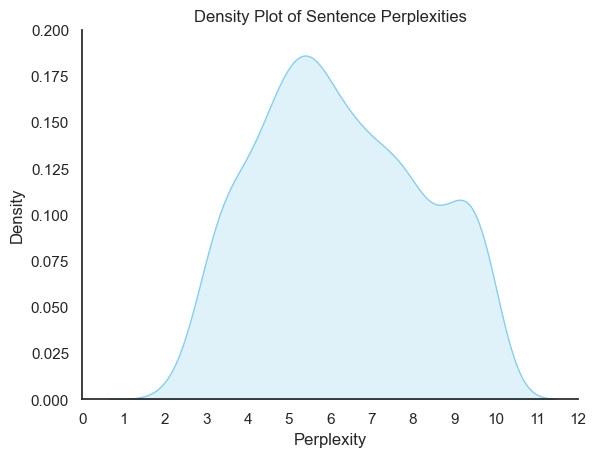

In [54]:
# Filter out sentence_perplexities > 10
filtered_sentence_perplexities = [p for p in sentence_perplexities if p <= 10]

sns.set_style('white')  # Set the plot style to white background
sns.kdeplot(filtered_sentence_perplexities, color='skyblue', fill=True)
plt.title('Density Plot of Sentence Perplexities')
plt.xlabel('Perplexity')
plt.ylabel('Density')

# Set the limits of x-axis and the ticks on the x-axis
plt.xlim(0, 10)
plt.xticks(range(0, 13))

plt.ylim(0, 0.2)  # Set the maximum value of the y-axis to 1

sns.despine()  # Remove the top and right spines

plt.show()

In [52]:
for i, perplexity in enumerate(sentence_perplexities):
    if perplexity < 0:
        print(f"Negative perplexity at index {i}: {perplexity}")